## Upper-extremity effort during the sit-to-stand task in able-bodied and spinal cord injury individuals: A preliminary study
Claudiane Fukuchi



Here is an exploration of the data set of the sit-to-stand (STS) task movement of 20 individuals (14 able-bodied  and 6 individuals with SCI).

All the individuals performed the STS task while sitting in a chair without back and arm-rest, using an instrumented walker.

The individuals had their STS task evaluated by 12 camera motion capture system at 100Hz (Vero 1.3, Vicon Motion Systems Ltd.), and by an instrumented walker and two force plates at 1000Hz (AMTI) to quantify the 3D kinematics and kinetics.

# Python libraries

In [3]:
import sys, os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import xlrd
from scipy import stats
from IPython.display import HTML
#import pyversions

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
pd.set_option('precision', 3)
import warnings
warnings.filterwarnings("ignore")

#pyversions.versions();

# Helper Functions

In [2]:
def pnorm(df):
    """Get the p-val of the normality (Shapiro-Wilk) test using the pingouin.
    """
    return pg.normality(df)['pval']


def sig_red(col, alpha=0.05):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    col = np.array([(float(x[1:]) if isinstance(x, str) else float(x))
                    if len(str(x)) else np.nan for x in col])
    
    is_sig = col < alpha
    return ['color: red' if x else 'color: black' for x in is_sig]


def describe(df, by=None, var=['mean', 'std', pnorm]):
    """Descriptive statistics for dataframe columns.
    """
    x = df.groupby(by).agg(var).stack().transpose()
    x.rename(columns={'pnorm': 'p'}, inplace=True)
    display(x.style.apply(sig_red, axis=0,
                          subset=[col for col in x.columns if col[-1] == 'p'])) 
    return x


def ttest(df, var, factor, levels=None, alpha=0.05):
    """t-test statistcs for dataframe columns using the pingouin library.
    """
    stats = pd.DataFrame()
    if levels is None:
        levels = df[factor].unique()
    if len(levels) != 2:
        raise Exception('Incorrect number of levels: {}'.format(len(levels)))
    for v in var:
        x = df[df[factor] == levels[0]][v]
        y = df[df[factor] == levels[1]][v]
        stat = pg.ttest(x, y)
        stat.index = [v]
        stats = pd.concat([stats, stat], axis=0)
    stats.drop(columns=['tail', 'BF10', 'power'], inplace=True)
    stats.index.name = '{}-{}'.format(*levels)
    display(stats.style.format({'p-val': '{:.3f}'}).apply(sig_red, subset='p-val', axis=1))
    return stats

# Meta data

In [4]:
name = 'MetaDataWalker.xlsx'
Winfo = pd.read_excel(name, header=0, index_col=None)
info = Winfo.drop_duplicates(subset='Group', inplace=False)
info

,Subject,Group,Age,Height,BodyMass,BMI
0,1,Control,24,1.71,84.36,28.85
14,15,SCI,23,1.69,50.38,17.64


# Groups (Control and SCI)

In [5]:
display(Winfo[['Subject', 'Group']].groupby(['Group']).count())

,Subject
Group,
Control,14
SCI,6


# Age, height, mass, and BMI

In [6]:
bmi = Winfo['BodyMass']/(Winfo['Height'])**2
Winfo['BMI'] = bmi.values

In [7]:
pd.set_option('precision', 2)
print('Mean and SD age values across individuals per group')
Winfo.groupby(['Group'])['Age','Height','BodyMass','BMI'].agg([np.mean, np.std])

Mean and SD age values across individuals per group


Age        Height       BodyMass           BMI      
          mean    std   mean   std     mean    std   mean   std
Group                                                          
Control  35.43  10.49   1.74  0.10    75.93  12.83  24.87  2.56
SCI      31.50   5.96   1.79  0.08    66.65  15.99  20.51  3.68

In [8]:
infoC = Winfo[Winfo['Group'] == 'Control']
infoS = Winfo[Winfo['Group'] == 'SCI']

In [9]:
listVars = ['Age','Height','BodyMass','BMI']
statistic, pvalue = stats.ttest_ind(infoC[listVars],infoS[listVars])

In [10]:
for v, variable in enumerate(listVars):
    if pvalue[v] < 0.05:
        print('\033[1m' + variable + ' p-value=' + str(np.round(pvalue[v],3)) 
              + '\033[0m')
    else:     
        print(variable + ' p-value=' + str(np.round(pvalue[v],3)))

Age p-value=0.405
Height p-value=0.291
BodyMass p-value=0.184
BMI p-value=0.007


Let's visualize the age, height, and body mass values by group of the individuals:

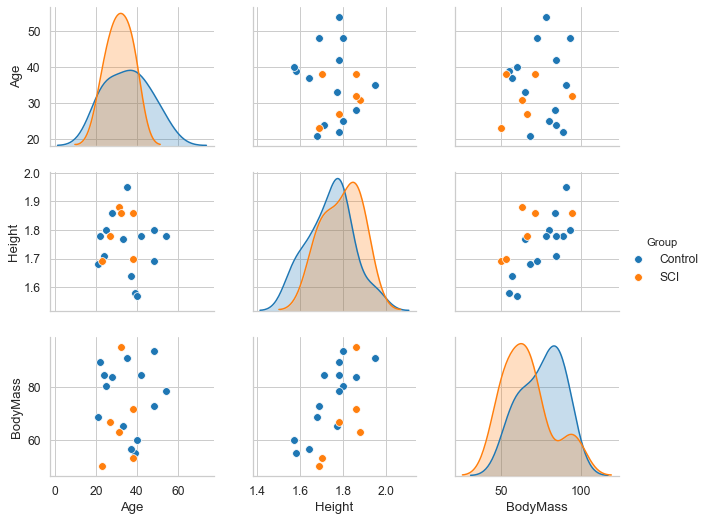

In [11]:
fig = sns.pairplot(Winfo[['Age', 'Height', 'BodyMass', 'Group']], hue='Group', size=2.5, aspect=1.2, plot_kws={'s':60})
plt.show()
fig.savefig("Histogram.png", dpi=300)

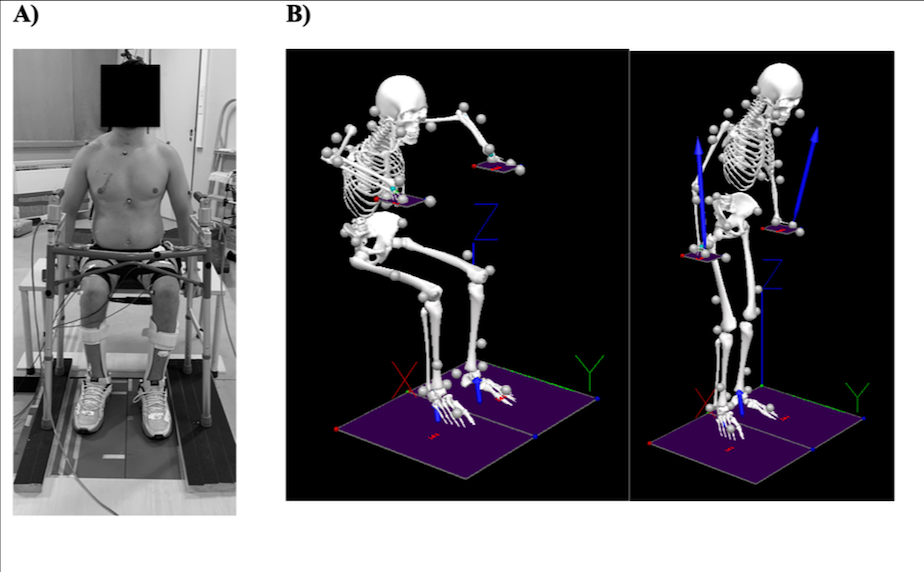

In [12]:
from IPython.display import Image
Image(filename='Figure1.png')

Figure: A) Set up protocol displaying an individual in the SCI group during the experiment. B) Animation showing the beginning (left) and the end of the sit-to-stand task cycle (right)

#  Descriptive Statistics 

In [13]:
# load data
name = 'WalkerData.xlsx'
data0 = pd.read_excel(name, header=0, index_col=None)

Example of the biomechanics variables analyzed before and after the seat-off of the STS task of the "SUB1"

In [14]:
info = data0.drop_duplicates(subset='TIME', inplace=False)
info

,SUB,GROUP,TIME,AGE,HEIGHT,BODYMASS,BMI,TrunkA,ShoulderA,ElbowA,WristA,ShoulderM,ElbowM,WristM,VerticalGRF,COG,Walker,Time2
0,1,Control,Before,24,1.71,84.36,28.85,32.59,120.88,118.97,-42.91,0.09,0.03,0.01,2.81,1.03,1.87,1.9
1,1,Control,After,24,1.71,84.36,28.85,43.49,120.03,125.72,-21.61,0.09,0.02,0.12,7.84,1.03,6.78,1.9


The STS cycle that was divided in two phases: before seat-off and after seat-off. 

In [15]:
display(HTML('<b>Number of individuals per group:</b>'))
display(data0[['SUB','GROUP','TIME']].groupby(['GROUP','TIME']).agg('count'))

var = ['GROUP','AGE','HEIGHT','BODYMASS','BMI']
info = data0.drop_duplicates(subset='SUB')[var]
describe(info, 'GROUP');
stats0 = ttest(info, var[1:], 'GROUP', levels=['Control','SCI'])

SUB
GROUP   TIME       
Control After    14
        Before   14
SCI     After     6
        Before    6

,T,dof,p-val,CI95%,cohen-d
Control-SCI,,,,,
AGE,1.1,16,0.305,[-3.93 11.79],0.42
HEIGHT,-1.2,12,0.259,[-0.15 0.04],0.53
BODYMASS,1.3,7.9,0.244,[-7.76 26.32],0.67
BMI,2.6,7.2,0.033,[0.48 8.24],1.5


In [16]:
features = ['ShoulderA','ElbowA','WristA','TrunkA','Time2',
            'ShoulderM','ElbowM','WristM',
            'VerticalGRF','Walker']

In [17]:
display(HTML('<b>Mean and STD values per group Control and SCI:</b>'))
df = data0[['GROUP','TIME']+features]
describe(df, ['GROUP','TIME'], var=['mean','std']);

agegroup = df.groupby('GROUP').agg(['mean', 'std']).stack().transpose()
table_msd = pd.concat([agegroup], axis=1)
display(table_msd)



GROUP       Control            SCI       
               mean    std    mean    std
ShoulderA    110.01  15.24  114.07  15.59
ElbowA       122.09  12.84  132.24   4.53
WristA       -13.91  33.46  -26.43  31.23
TrunkA        34.91  10.71   43.92   8.88
Time2          2.45   0.65    3.21   0.52
ShoulderM      0.11   0.13    0.20   0.18
ElbowM         0.10   0.12    0.09   0.09
WristM         0.06   0.08    0.11   0.10
VerticalGRF    4.58   2.78    3.29   1.20
Walker         4.14   3.01    6.23   2.49

#### Simple tests for differences between groups: Control x SCI 

In [18]:
var = ['GROUP','TIME'] + features 
print('Before seat-off')
stats0 = ttest(data0[data0['TIME']=='Before'][var], var[2:], 'GROUP', levels=['Control', 'SCI'])

print('After seat-off')
stats0 = ttest(data0[data0['TIME']=='After'][var], var[2:], 'GROUP', levels=['Control', 'SCI'])

Before seat-off


,T,dof,p-val,CI95%,cohen-d
Control-SCI,,,,,
ShoulderA,-0.45,9.1,0.664,[-21.25 14.21],0.22
ElbowA,-3.6,17,0.002,[-22.36 -5.8 ],1.2
WristA,0.44,11,0.670,[-15.52 23.21],0.2
TrunkA,-2.5,8,0.035,[-19.84 -0.91],1.3
Time2,-2.7,11,0.021,[-1.39 -0.14],1.2
ShoulderM,0.71,8.1,0.501,[-0.06 0.11],0.37
ElbowM,-0.2,6.4,0.848,[-0.04 0.03],0.12
WristM,-0.84,8.4,0.426,[-0.03 0.01],0.43
VerticalGRF,-0.46,8.4,0.660,[-1.05 0.7 ],0.24


After seat-off


,T,dof,p-val,CI95%,cohen-d
Control-SCI,,,,,
ShoulderA,-0.58,9.1,0.574,[-22.37 13.18],0.29
ElbowA,-1.9,17,0.075,[-13.14 0.7 ],0.71
WristA,1.1,8.5,0.299,[-22.57 64.97],0.57
TrunkA,-3,18,0.008,[-13. -2.29],1.1
Time2,-2.7,11,0.021,[-1.39 -0.14],1.2
ShoulderM,-3.2,13,0.007,[-0.33 -0.06],1.3
ElbowM,0.43,13,0.674,[-0.1 0.14],0.18
WristM,-2.1,9.9,0.057,[-0.16 0. ],1
VerticalGRF,5.3,18,0.000,[1.67 3.85],1.9


In [19]:
features2 = ['ShoulderA','ElbowA','WristA','TrunkA','TrunkA','ShoulderM','ElbowM','WristM','Walker','VerticalGRF']
labels2 = ['Shoulder (deg)','Elbow (deg)','Wrist (deg)','Trunk (deg)','Trunk (deg)','Shoulder (Nm/kg)','Elbow (Nm/kg)','Wrist (Nm/kg)','Walker (N/kg)','GRF (N/kg)']

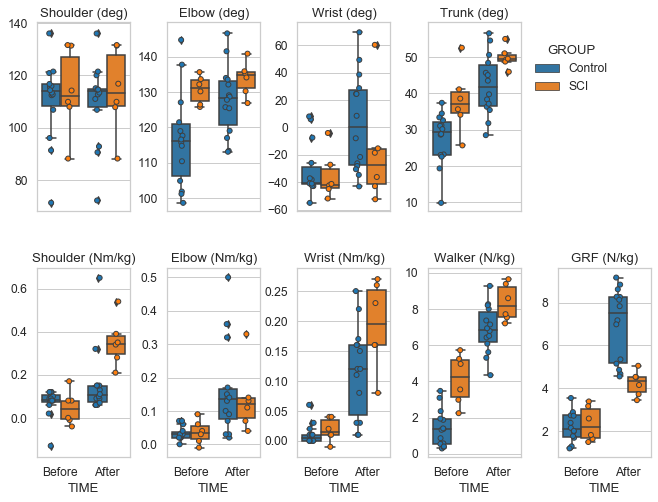

In [20]:
variables = features2
fig, axs = plt.subplots(2, 5, figsize=(11, 8), sharex=True, gridspec_kw={'hspace': .3, 'wspace': .4})
axs = axs.flatten()
fig.delaxes(axs[4])

for i, ax, v, label in zip(range(len(axs)), axs, variables, labels2):
    sns.stripplot(x='TIME', y=v, data=data0, ax=ax, hue='GROUP', jitter=True,
                  edgecolor='gray', linewidth=1, dodge=True)
    sns.boxplot(x='TIME', y=v, data=data0, ax=ax, hue='GROUP')
    handles, labels3 = ax.get_legend_handles_labels()
    if i == 3:
        ax.legend(handles[:2], labels3[:2], frameon=False, loc=[1.1,.6], title='GROUP')
    else:
        ax.get_legend().remove()
    ax.set_title(label)
    if i < 4:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    ax.set_ylabel('')
    #ax.set_ylim([np.min(y)-.5,np.max(y)+.5])

#fig.delaxes(axs[9])
plt.show()

#fig.savefig('AnglesMoments_GRF.png')